# Tutorial on Classification I: Generative models

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F05_tutorial_classification_generative.ipynb)

Tutorial to the class [Classification I: Generative models](05_classification_generative.ipynb).

<div class="alert alert-block alert-success">
    <b>Context</b>
    
- Era5 data set: surface data at paris.
- Linear discriminant analysis

</div>

### Prediction of the rain

Prediction of the rain remains one of the most challenging task in numerical weather prediction. In fact the rain is the result of multiple scale phenomena: from the large-scale organization of weather system to the small scale microphysics of dropplet formation. Getting the right prediction for the rain implies that we have a model that captures well all these scales.

Despite the fact that rain is hard to predict, there seem to be exist a correspondance between the surface pressure and the weather conditions as shown in the picture below:

<img alt="Barometer" src="images/barometer.jpg">


## Data set

The data we are going to use in this notebook comes from the [ERA5 data base](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels). To quote ECMWF: *Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset using the laws of physics.* In the ERA5 data base, we can find 4d fields (time, latitude, longitude, height) such as temperature, wind, humidity, clouds, precipitation, etc... The time resolution is 1 hour, horizontal grid spacing is approx 20 km and vertical resolution varies with high resolution near the ground and coarse resolution near the top of the atmosphere.

To illustrate this notebook, I prepared a data set with surface variables only at a given location between 2000 and 2009 at the hourly resolution.

The variables in this data set are the raw variables that you can find in the ERA reanalysis

| Variable name  | Description                             | Unit    |
| :------------- | :-------------                          | :------ |
| t2m            | Air temperature at 2 m above the ground | [K]     |
| d2m            | [Dew point](https://en.wikipedia.org/wiki/Dew_point) at 2 m above the ground       | [K]     |
| u10            | Zonal wind component at 10 m            | [m/s]   |
| v10            | Meridional wind component at 10 m       | [m/s]   |
| skt            | Skin temperature                        | [K]     |
| tcc            | Total cloud cover                       | [0-1]   |
| sp             | Surface pressure                        | [Pa]    |
| tp             | Total precipitation                     | [m]     |
| ssrd           | Surface solar radiation (downwards)     | [J/m^2] |
| blh            | Boundary layer height                   | [m]     |






In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("data/era5_paris_sf_2000_2009.csv", index_col='time', parse_dates=True)

In [3]:
df.describe()

,skt,u10,v10,t2m,d2m,tcc,sp,tp,ssrd,blh
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,8.767200e+04,87672.000000
mean,283.811469,1.063173,0.542577,284.102522,280.603131,0.674363,100306.215302,0.000081,4.692709e+05,592.633676
std,7.282320,2.920556,3.055488,6.615780,5.536824,0.356627,946.710936,0.000285,7.169155e+05,436.894806
min,258.046500,-8.554123,-8.692932,260.682980,258.580700,0.000000,95585.560000,0.000000,-1.429965e-03,10.763875
25%,278.694565,-1.201481,-1.761349,279.443792,276.807730,0.383133,99755.795000,0.000000,0.000000e+00,215.325750
50%,283.566100,1.155563,0.384865,284.094120,281.082300,0.835373,100369.515000,0.000000,2.118400e+04,505.917295
75%,288.581330,3.045872,2.631916,288.708078,284.839027,0.996002,100914.701250,0.000000,7.436800e+05,898.669800
max,313.901800,14.185852,14.439499,309.334100,296.104550,1.000000,102814.060000,0.005638,3.233472e+06,2987.135000


Take a moment to explore this data set. In this tutorial, we will be interested in the precipitation variable `tp`, the surface pressure `sp`, and the air temperature near the surface `t2m`. You can plot time series of these variables for the entire data set or for limited periods of time.

Remember that you can use the index `df.index` to select part of the dataset: e.g. `df.index.year == 2000` or `df.index >= '2000-01-01'`. 

For more advanced users, you can compute the seasonal cycle with `.groupby(df.index.month).mean()`

<AxesSubplot:xlabel='time'>

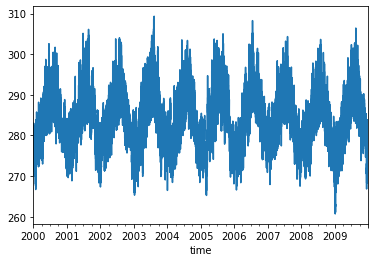

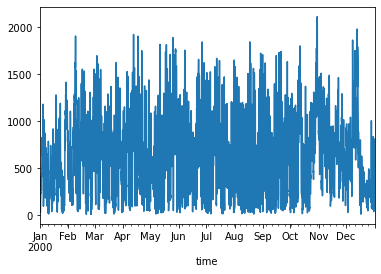

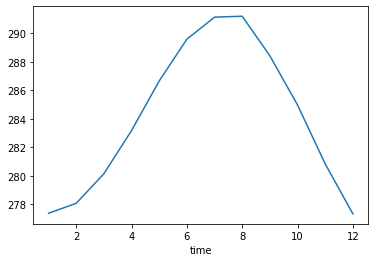

In [4]:
# Explore the data set here. 
# You can add more cells if needed.
plt.figure()
df['t2m'].plot()
plt.figure()
df['blh'][(df.index >= '2000') & (df.index < '2001')].plot()

plt.figure()
df['t2m'].groupby(df.index.month).mean().plot()

> ***Question (optional)***
> - Which variables hexhibit a seasonal cycle? a daily cycle? Could you have anticipated this result?

In [5]:
# Variables that have pronounced seasonal cycle: skin temperature, temperature, dew point and solar radiation.
# These are thermodynamic variable that vary with the incoming solar radiation.
# The other variables do not have pronounced seasonal cycle.

Can you build a new normalized data set called `df_norm`. You can simply achieve this by subtracting the mean and dividing by the standard deviation. 

In [6]:
# your code here
df_norm = (df - df.mean()) /df.std()

In the same figure, plot a time series of the total precipitation `tp` and surface pressure `sp`. You can plot this time series for a month in winter and a month in summer.

> ***Question***
> - Do you observe any correlation between rain and pressure?

<AxesSubplot:xlabel='time'>

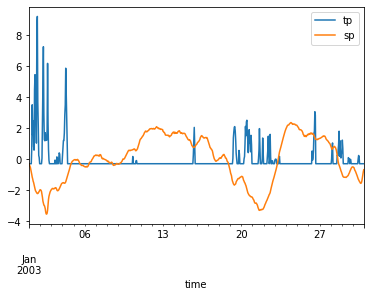

In [7]:
# your code here
df_norm[['tp', 'sp']][(df.index >= '2003-01-01') & (df.index < '2003-01-31')].plot()

As you can see (if you zoom enough),  rain is very noisy data set. Indeed, if you observe the rain pattern, it is often very localized. This is also the reason why it is very hard to predict. In order to smooth the data, we are going to work with daily averages. Use the `.resample` method to to get daily averages.

In [8]:
# your code here
df_day = df_norm.resample("D").mean()

Let's classify the days into two classes: "Rain", "Dry". Because we use normalized data, the amount of precipitation of dry days is not zero but is close to $-0.2$. We use this value which corresponds roughly to $0.5$ mm/day.

In [9]:
# normalized threshold (corresponds to 0.5 mm/day)
precip_th = -0.2
df_day['tag'] = df_day['tp'].where(df_day['tp']> precip_th, 0)
df_day['tag'] = df_day['tag'].where(df_day['tp']<= precip_th, 1)

Use the function `plt.scatter` to plot a scatter plot of rain classification in the (pressure, temperature) space (`sp`, `t2m`). You need to adjust the color of the points so that we can see which category they belong to. Don't forget to add labels to your plot.

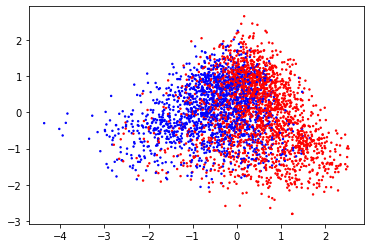

In [10]:
# your code here
plt.scatter(df_day['sp'], df_day['t2m'],s=2,c=df_day['tag'],cmap=plt.cm.bwr_r)

Use the .boxplot to plot the percentiles of the pressure distribution for the rainy days and dry days. Keywords that could be useful here are `column`, `by` and if you feel like it `patch_artist = True`

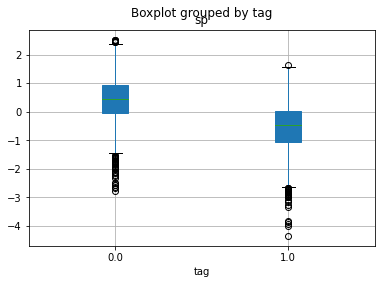

In [11]:
# your code here
boxplot = df_day.boxplot(column=['sp'], by='tag',patch_artist = True,return_type='both')

Let's split our dataset into a training set and a testing set. For this tutorial, we will only keep surface pressure `sp` as our input feature. Uncomment the lines below to generate the training and testing data sets.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_day[['sp']],df_day['tag'],test_size=.3,random_state=0)

For now on, we will train our model an `X_train` and `y_train`. Later on, we will validate our results with `X_test` and `y_test`.

> - What is the number of day in each class?
> - What is the probability of having a rainy day in this data set?

In [13]:
# your code here
N_tot = y_train.count()
N_rain = y_train.sum()

Prior_rain = N_rain/N_tot

Prior_class = np.array([1-Prior_rain, Prior_rain])
print(f"There are {N_rain:.0f} days out of {N_tot}")
print(f"The probability to draw a rainy day is {Prior_rain:.2f}")

There are 1103 days out of 2557
The probability to draw a rainy day is 0.43


In order to compute the linear discriminant analysis, we need to compute the mean and covariance matrix of each class

> - What is the mean of each class? (Use the method `.groupby(y_train)`)

In [14]:
#your code here
mu_class = X_train.groupby(y_train).mean().values
mu_class

array([[ 0.41480676],
       [-0.60305365]])

> - What is the covariance matrix of each class? (Same hint)

In [15]:
#your code here
cov_class = X_train.groupby(y_train).cov().values

> - What is the weighted sum of the two covariance matrices

In [16]:
# your code here
sigma2 = (cov_class[0]*(1-Prior_rain) + cov_class[1]*Prior_rain)
sigma2

array([0.69933448])

Suppose rain is only function of pressure.

> - Compute the numerical coefficients of the two discriminant functions $\delta_k(x) = x\frac{\mu_k}{\sigma^2} - \frac{\mu_k^2}{2\sigma^2} + \log P_k$

Class: k=1

mu_0 = [0.41480676]
Prior_0 = 0.5686351192804067

Class: k=1

mu_1 = [-0.60305365]
Prior_1 = 0.4313648807195933



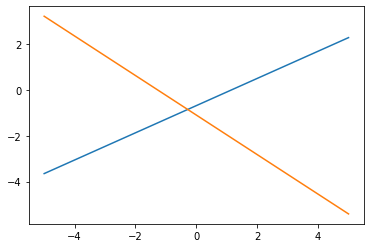

In [17]:


for k in range(0,2):
    print("Class: k=1\n")
    print(f"mu_{k} = {mu_class[k]}")
    print(f"Prior_{k} = {Prior_class[k]}\n")


def delta_class (x, k):
    return x*mu_class[k]/sigma2 - mu_class[k]**2/(2*sigma2) + np.log(Prior_class[k])

xtest = np.linspace(-5,5,10)
plt.plot(xtest,delta_class(xtest,0))
plt.plot(xtest,delta_class(xtest,1))

What is the threshold pressure to discriminate between rainy days and dry days

We have $\delta_0(x) = \delta_1(x)$ when 

\begin{equation}
x = \frac{\mu_0 + \mu_1}{2} + \sigma^2 \log\frac{P_1}{P_0}
\end{equation}

In [18]:
x_th = np.mean(mu_class) + sigma2*np.log(Prior_class[1]/Prior_class[0])
print(f"The threshold pressure is x={x_th}")

The threshold pressure is x=[-0.28733882]


> ***(Optional)***
> - Same question but in the 2d space (pressure, temperature)
> - Plot this decision boundary on top of your scatter plot

We recall 

\begin{equation}
\delta_k (\mathbf x) = \mathbf x^\top \Sigma^{-1} \mathbf \mu_k - \frac{1}{2}\mathbf \mu_k^\top \Sigma^{-1} \mathbf \mu_k  + \log(P_k)
\end{equation}

the boundary is $\mathbf x$ such that
\begin{equation}
\delta_0 (\mathbf x) = \delta_1 (\mathbf x)
\end{equation}

we write 

\begin{equation}
\mathbf v_0 = \Sigma^{-1} \mathbf \mu_0
\end{equation}

\begin{equation}
\mathbf v_1 = \Sigma^{-1} \mathbf \mu_1
\end{equation}

we have 
\begin{equation}
\mathbf x^\top \mathbf v_0 - \frac{1}{2}\mathbf \mu_0^\top  \mathbf v_0  + \log(P_0) = \mathbf x^\top \mathbf v_1 - \frac{1}{2}\mathbf \mu_1^\top  \mathbf v_1  + \log(P_1)
\end{equation}

\begin{equation}
\mathbf x^\top (\mathbf v_0 - \mathbf v_1) =  \frac{1}{2}(\mathbf \mu_0^\top  \mathbf v_0 - \mathbf \mu_1^\top  \mathbf v_1)  + \log(\frac{P_1}{P_0})
\end{equation}

if we write $\mathbf v_0 - \mathbf v_1 = [\alpha, \beta]^\top$ 

and 

\begin{equation}
\gamma =  \frac{1}{2}(\mathbf \mu_0^\top  \mathbf v_0 - \mathbf \mu_1^\top  \mathbf v_1)  + \log(\frac{P_1}{P_0})
\end{equation}

Then the equation of the boundary is 

\begin{equation}
\alpha x + \beta y = \gamma
\end{equation}

or 

\begin{equation}
y = -\frac{\alpha}{\beta} x + \frac{\gamma}{\beta}
\end{equation}

(-4, 4)

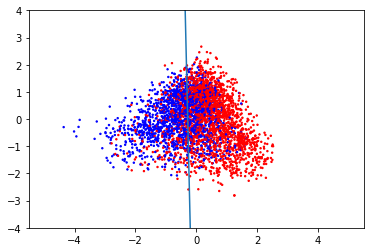

In [19]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df_day[['sp', 't2m']],df_day['tag'],test_size=.3,random_state=0)

mu2_class = X2_train.groupby(y2_train).mean().values
cov2_class = X2_train.groupby(y2_train).cov().values
sigma2 = (cov2_class[0:2,:]*(1-Prior_rain) + cov2_class[2:,:]*Prior_rain)
mu2_class

#see definition above
v0 = np.linalg.solve(sigma2,mu2_class[0,:])
v1 = np.linalg.solve(sigma2,mu2_class[1,:])

gamma = (v0@mu2_class[0,:] - v1@mu2_class[1,:])/2 + np.log(Prior_class[1]/Prior_class[0])
alpha = (v0 - v1)[0]
beta = (v0 - v1)[1]

y_bdy = (-alpha*xtest+gamma)/beta
plt.scatter(df_day['sp'], df_day['t2m'],s=2,c=df_day['tag'],cmap=plt.cm.bwr_r)
plt.plot(xtest,y_bdy)
plt.ylim([-4,4])

We find that the boundary is almost vertical. This means that the temperature does not play a fundamental role in the prediction of the rain.

Let's analyze the Linear discriminant analysis provided by scikit-learn 

In [20]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

What is the class prediction according to this Linear Discriminant Analysis?

In [21]:
# your code here
y_pred = lda.predict(X_test)

What is the overall accuracy of our predictor? You can use the `classification_report` function.

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80       646
         1.0       0.73      0.59      0.66       450

    accuracy                           0.74      1096
   macro avg       0.74      0.72      0.73      1096
weighted avg       0.74      0.74      0.74      1096



You can look more closely at the results with the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))

[[549  97]
 [183 267]]


Do you get a completely different confusion matrix with the test data than with the train data?

In [24]:
y_pred_train = lda.predict(X_train)
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))

[[1208  246]
 [ 434  669]]
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78      1454
         1.0       0.73      0.61      0.66      1103

    accuracy                           0.73      2557
   macro avg       0.73      0.72      0.72      2557
weighted avg       0.73      0.73      0.73      2557



> ***Questions***
> - Do you feel you have built a good predictor? 
> - What would be the score of a predictor that would predict rain every day? dry every day? 
> - What about a completely random predictor?
> - What do you think of the [picture of the barometer](#Prediction-of-the-rain) at the beginning of this tutorial?

#### Further reading

> - Read about the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and try to use the scikit-learn module to plot it.
> - Does the Quadratic discriminant analysis performs better on this data set?

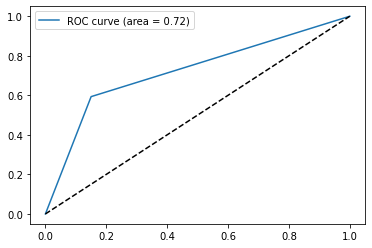

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thr = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr , label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], 'k--')
plt.legend()

In [26]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train,y_train)
y_pred = qda.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79       646
         1.0       0.73      0.58      0.65       450

    accuracy                           0.74      1096
   macro avg       0.74      0.72      0.72      1096
weighted avg       0.74      0.74      0.73      1096



***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>